## Data Processing and Meta Cell Construction

In [1]:
Sys.setenv(LANGUAGE = "en")
options(warn = -1)

library(GenomicRanges)
library(GenomicFeatures)
library(slingshot)
library(Seurat)
library(Signac)
library(tidyverse)
source('R/mytools.R')

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: AnnotationDbi



In [ ]:
mgene_coding_use <- readRDS('data/out/mgene_coding_use.rds')
degs <- read_tsv("data/out/cluster_all_degs_from_analysis2.tsv.gz",show_col_types = FALSE)

In [3]:
sm <- c(
  "data/matrix/part2/RNAPII_RNAPII-Brg1_r1_5kbin.rds",
  "data/matrix/part2/RNAPII_RNAPII-H3K27ac_r1_5kbin.rds",
  "data/matrix/part2/RNAPII_RNAPII-H3K4me3_r1_5kbin.rds",
  "data/matrix/part3/RNAPII_RNAPII-MyoD_r1r2_5kbin.rds",
  "data/matrix/part3/RNAPII_RNAPII-Myog_r1_5kbin.rds"
  ) %>%
  map(readRDS) %>%
  ldecoyMerge()
dim(sm)

[1] 521942  41474

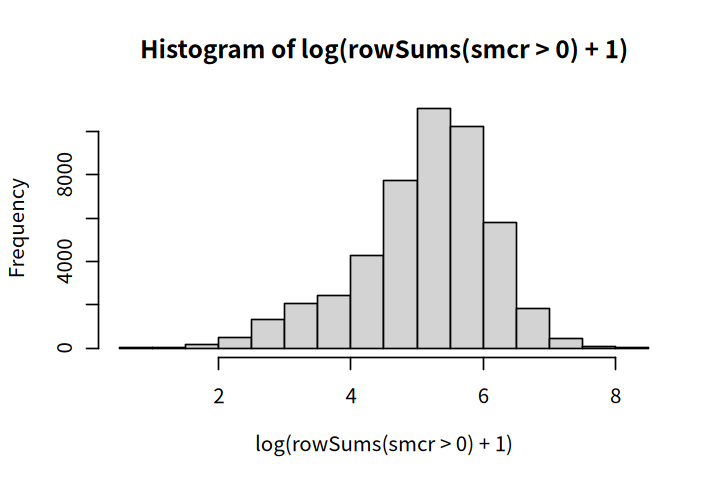

In [4]:
ug <- degs %>% 
  filter(p_val_adj < .1) %>%
  pull(gene)
mgene_codingreg_ <- mgene_coding_use[mgene_coding_use$symbol %in% ug] %>% 
  extend(-1000,1000) %>% GenomicRanges::reduce()
codingreg <- reg2gr(rownames(sm)) %>% findOverlapPairs(mgene_codingreg_) %>% 
  .@first %>% unique() %>% sort() %>% gr2reg() %>% gsub("-","_",.)
smcr <- sm[codingreg,]

options(repr.plot.width = 6, repr.plot.height = 4) 
hist(log(rowSums(smcr>0)+1))

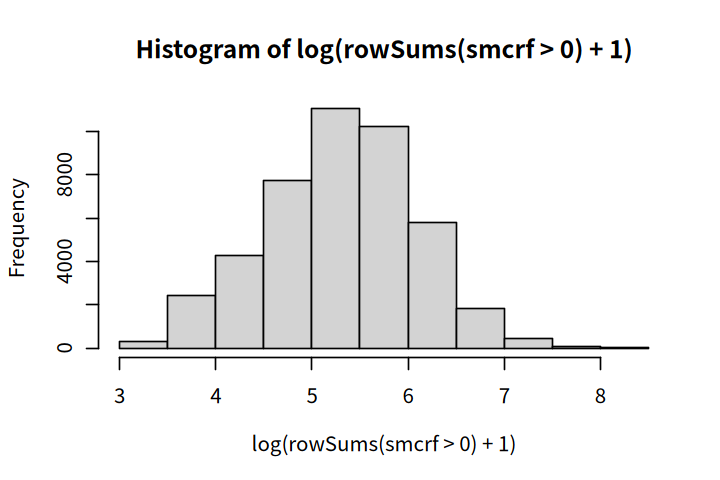

In [5]:
smcrf <- smcr[rowSums(smcr>0)>30,]

options(repr.plot.width = 6, repr.plot.height = 4) 
hist(log(rowSums(smcrf>0)+1))

In [6]:
smcrf <- smcrf[,colSums(smcrf>0)>50]
dim(smcrf)

[1] 44178 40617

In [7]:
df_obs <- tibble(
  cell = colnames(smcrf),
  nCount = colSums(smcrf),
  nFeature = colSums(smcrf>0)
  ) %>%
  separate(cell,into = c("rep","sample","pair","ab","lib_id","t5"),remove = F) %>%
  select(-lib_id,-t5) %>%
  unite(batch,pair,rep,remove = F)
df_var <- tibble(
  region = rownames(smcrf),
  nCell = rowSums(smcrf>0)
  ) 

Matrix::writeMM(smcrf,'data/mtx_filtered/RNAPII_count.mtx')
write_csv(df_obs,'data/mtx_filtered/RNAPII_obs.csv')
write_csv(df_var,'data/mtx_filtered/RNAPII_var.csv')

NULL

Batch correction and denoising were performed according to '4_1_2_denoising_RNAPII_count.ipynb'.  
- model : 'data/out/peakvi_out/RNAPII_model.pkl'.
- denoised count : 'data/out/denoised/RNAPII_denoised.csv'.

In [8]:
## load data processed by peakVI

la <- read_delim('data/out/peakvi_out/RNAPII_latent.csv',col_names = F,show_col_types = F)
obs <- read_delim('data/out/peakvi_out/RNAPII_obs.csv',col_names = T,show_col_types = F) %>%
  mutate(sample = factor(sample,levels = c('MyoDminus','D0','D24','D72')))
um <-  read_delim('data/out/peakvi_out/RNAPII_umap.csv',col_names = F,show_col_types = F) %>%
  rename(UMAP1 = 1,UMAP2 = 2)
seu <- CreateChromatinAssay(sm[,obs$cell],sep = c("_","_"))
seu <- CreateSeuratObject(seu,meta = tib2df(obs),assay = 'peak')
seu <- RunTFIDF(seu,scale.factor = 3000)

um_ <- um %>%
  mutate(cell = obs$cell) %>%
  tib2df(RowNames = 'cell') %>%
  as.matrix() %>%
  CreateDimReducObject(key = 'UMAP',assay = 'peak')
seu[['umap']] <- um_

la_ <- la %>%
  mutate(cell = obs$cell) %>%
  tib2df(RowNames = 'cell') %>%
  as.matrix() %>%
  CreateDimReducObject(key = 'peakVI',assay = 'peak')
seu[['peakvi']] <- la_

Performing TF-IDF normalization



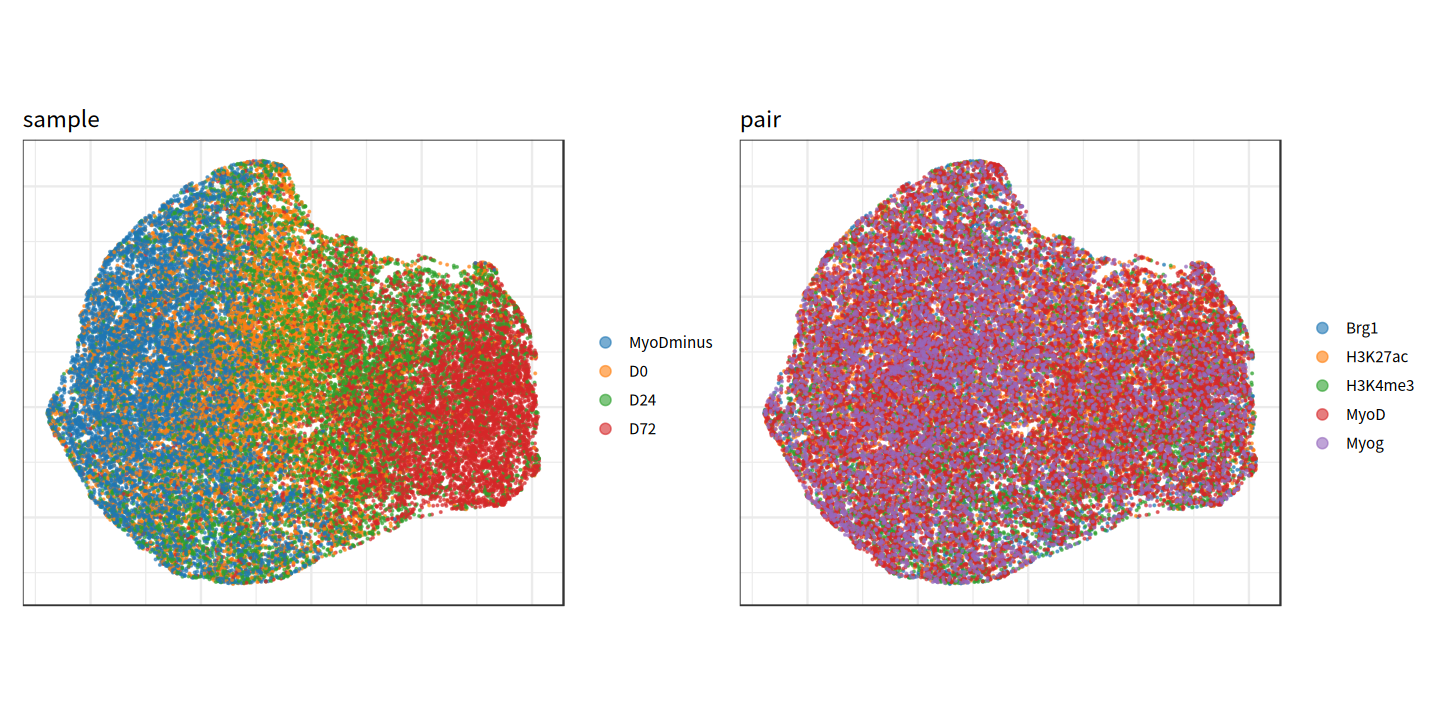

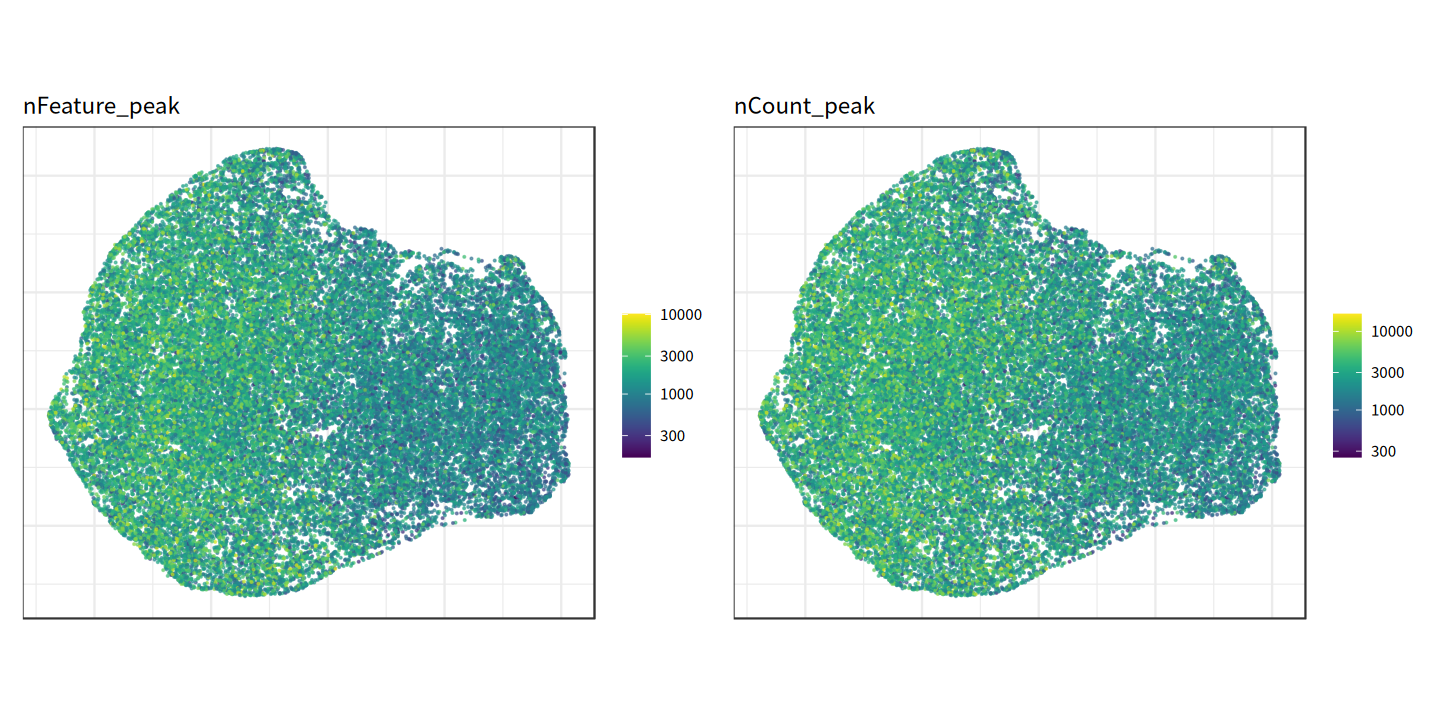

In [9]:
options(repr.plot.width = 12, repr.plot.height = 6) 
dimplot(seu,c('sample','pair'),scale_color_log10 = T,alpha = .6)
dimplot(seu,c('nFeature_peak','nCount_peak'),scale_color_log10 = T,alpha = .6)

In [10]:
## Construction of meta cells
#
# source("R/GeneTrajectory_mod.R")
# cell.graph.dist <- GetGraphDistance_(Embeddings(seu[['peakvi']]),K = 10,dims = 1:5)
# pre_cg_output <- pre.coarse.grain(cell.embedding = Embeddings(seu[['peakvi']])[,1:5], graph.dist = cell.graph.dist,N = 1000)
# 
# saveRDS(pre_cg_output,'data/out/pre_cg_output_1k.rds')
# as(pre_cg_output$KNN.membership.mat,'sparseMatrix') %>%
#      Matrix::writeMM('data/out/pre_cg_output_KNNmembership_1k.mtx')
# tibble(cell = colnames(pre_cg_output$KNN.membership.mat)) %>%
#   write_csv('data/out/pre_cg_output_obs_1k.csv')

In [11]:
pre_cg_output <- readRDS('data/out/pre_cg_output_1k.rds')

In [12]:
labs <- pre_cg_output$KNN.membership.mat %>%
  colnames() %>% str_split(pattern = "_") %>% 
  map(~{.[3]}) %>% unlist() %>%
  as.factor()
a <- pre_cg_output$KNN.membership.mat %>%
  apply(1,function(x) table(labs[x>0])) %>% t()
rownames(a) <- sprintf('ic%04d',1:nrow(a))

nic <- 1000
aa <- rowSums(a)
useic <- names(aa)[aa>20]
lab <- seu$sample
pop_sample <- apply(pre_cg_output$KNN.membership.mat,1,function(x) table(lab[x>0])) %>%
  t() %>% as_tibble() %>%
  mutate(cell = sprintf("ic%04d",1:nic)) %>%
  filter(cell %in% useic)
pop_sample <- pop_sample %>%
  mutate(major = colnames(pop_sample)[apply(pop_sample[,1:4],1,which.max)]) %>%
  gather(key = ori,value = n,-c(cell,major)) %>%
  mutate(major = factor(major,levels = levels(seu$sample)),
         ori = factor(ori,levels = levels(seu$sample))) %>%
  arrange(major,-n) %>%
  mutate(cell = factor(cell,levels = unique(cell)))

lab <- as.factor(seu$pair)
pop_pair <- apply(pre_cg_output$KNN.membership.mat,1,function(x) table(lab[x>0])) %>%
  t() %>% as_tibble() %>%
  mutate(cell = sprintf("ic%04d",1:nic)) %>%
  filter(cell %in% useic)
sf <- colSums(pop_pair[,1:5])
pop_pair <- pop_pair %>%
  mutate(major = colnames(pop_pair)[apply(t(pop_pair[,1:5])/sf,2,which.max)]) %>%
  gather(key = ori,value = n,-c(cell,major)) %>%
  mutate(cell = factor(cell,levels = levels(pop_sample$cell)))

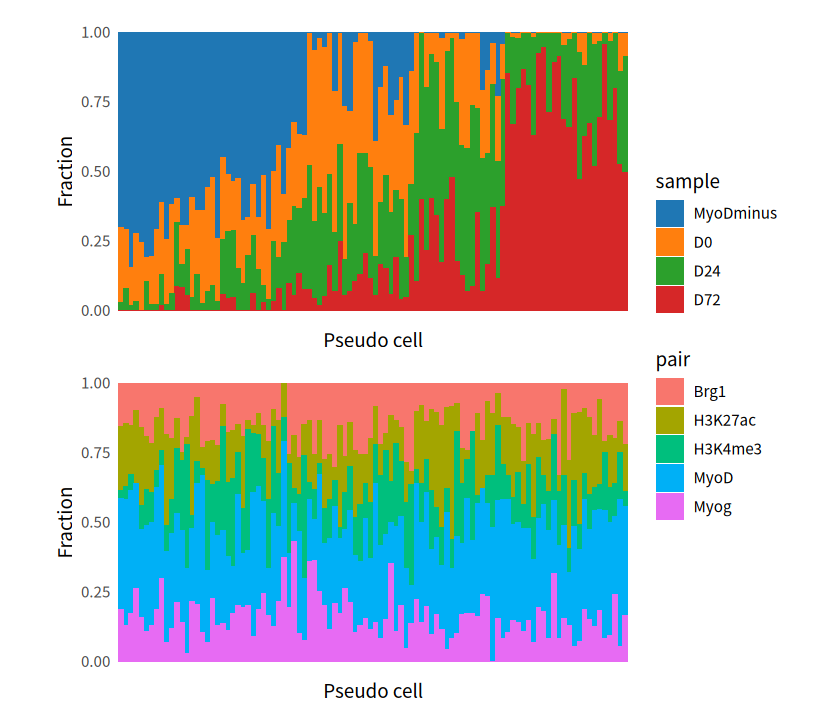

In [13]:
set.seed(1000); idx <- useic[sample(length(useic),100)]
pop_sample_ <- pop_sample %>% filter(cell %in% idx)
pop_pair_ <- pop_pair %>% filter(cell %in% idx)
g <- list(
  pop_sample_  %>% 
    ggplot(aes(cell,n,fill = ori)) + 
      geom_bar(stat = 'identity',position = 'fill') + 
      labs(x = 'Pseudo cell',y = 'Fraction',fill = 'sample') + dfill,
  pop_pair_ %>%
    ggplot(aes(cell,n,fill = ori)) + 
      geom_bar(stat = 'identity',position = 'fill') + 
      labs(x = 'Pseudo cell',y = 'Fraction',fill = 'pair')
  ) %>%
  patchwork::wrap_plots(guides = 'collect',ncol = 1) &
  theme_minimal() &
  theme(panel.grid = element_blank(),axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),aspect.ratio =.6) 

options(repr.plot.width = 7, repr.plot.height = 6) 
g 

In [14]:
ct <- GetAssayData(seu,layer = 'counts') %*% t(pre_cg_output$KNN.membership.mat)
ct <- as(ct,'sparseMatrix')
colnames(ct) <- sprintf("ic%04d",1:nic)
ct <- ct[,useic]

meta <- pop_sample %>%
  reframe(n = sum(n),.by = c(cell,major)) %>%
  rename(sample = major,nCell = n) %>%
  left_join(
    pop_pair %>%
      distinct(cell,major) %>%
      rename(pair = major),
    by = 'cell'
  ) %>%
  tib2df()
seu_ic <- CreateSeuratObject(counts = ct,meta = meta,assay = 'RNAPII')
seu_ic <- AddMetaData(seu_ic,metadata = meta)

tes <- t(t(Embeddings(seu[['peakvi']])) %*% t(pre_cg_output$KNN.membership.mat))
rownames(tes) <- sprintf("ic%04d",1:nic)
tes <- tes[useic,]
tes2 <- CreateDimReducObject(as.matrix(tes),assay = 'RNAPII',key = 'peakvi')

seu_ic[['peakvi']] <- tes2
seu_ic <- RunUMAP(seu_ic,reduction = 'peakvi',dims = 1:5)

10:08:17 UMAP embedding parameters a = 0.9922 b = 1.112

10:08:17 Read 944 rows and found 5 numeric columns

10:08:17 Using Annoy for neighbor search, n_neighbors = 30

10:08:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:08:17 Writing NN index file to temp file /tmp/Rtmp8gcpTk/file2cc74e695031d9

10:08:17 Searching Annoy index using 1 thread, search_k = 3000

10:08:17 Annoy recall = 100%

10:08:18 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:08:20 Initializing from normalized Laplacian + noise (using RSpectra)

10:08:20 Commencing optimization for 500 epochs, with 29956 positive edges

10:08:20 Using rng type: pcg

10:08:22 Optimization finished



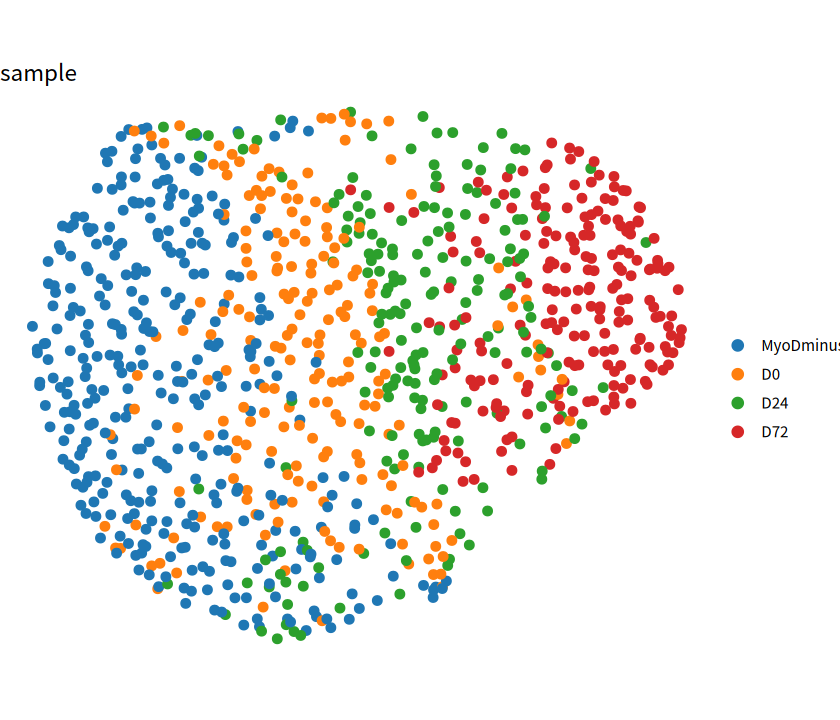

In [15]:
dimplot(seu_ic,'sample',size = 2,Theme = theme_void)

## Processing the counts of paired targets

In [ ]:
path <- c(
  Brg1 = "data/matrix/part2/Brg1_RNAPII-Brg1_r1_5kbin.rds",
  H3K27ac = "data/matrix/part2/H3K27ac_RNAPII-H3K27ac_r1_5kbin.rds",
  H3K4me3 = "data/matrix/part2/H3K4me3_RNAPII-H3K4me3_r1_5kbin.rds",
  MyoD = "data/matrix/part3/MyoD_RNAPII-MyoD_r1r2_c2c12peak.rds",
  Myog = "data/matrix/part3/Myog_RNAPII-Myog_r1_c2c12peak.rds"
  )
md_peaks <- read_tsv("data/out/MyoD_accum_dyn.tsv.gz",show_col_types = F)
mg_peaks <- read_tsv("data/out/Myog_accum_dyn.tsv.gz",show_col_types = F)
regs <- list(MyoD = md_peaks$peak,Myog = mg_peaks$peak)
allcells <- pull(read_tsv("data/out/usedcells.tsv.gz",show_col_types = F),cell)

In [17]:
for(i in names(path)){
  mat <- readRDS(path[i])
  mat <- mat[,intersect(colnames(mat),allcells)]
  if(i %in% c("Brg1","H3K27ac","H3K4me3")){
    smf <- mat[rowSums(mat>0)>30,]
  }else{
    a <- intersect(rownames(mat),regs[[i]])
    smf <- mat[a,]
  }
  df_obs <- tibble(
    cell = colnames(smf),
    nCount = colSums(smf),
    nFeature = colSums(smf>0)
    ) %>%
    separate(cell,into = c("rep","sample","pair","ab","lib_id","t5"),remove = F) %>%
    select(-lib_id,-t5) %>%
    unite(batch,pair,rep,remove = F)
  df_var <- tibble(
    region = rownames(smf),
    nCell = rowSums(smf>0)
    ) 
  Matrix::writeMM(smf,sprintf('data/mtx_filtered/%s_count.mtx',i))
  write_csv(df_obs,sprintf('data/mtx_filtered/%s_obs.csv',i))
  write_csv(df_var,sprintf('data/mtx_filtered/%s_var.csv',i))
}

In [18]:
abs <- c('Brg1','H3K27ac','H3K4me3','MyoD','Myog')
vars <- list()
mgene_codingreg_n <- mgene_coding_use[mgene_coding_use$symbol %in% ug]
mgene_codingregs <- list(
  Brg1 = extend(mgene_codingreg_n,upstream = 5000,downstream = 0),
  H3K27ac = extend(mgene_codingreg_n,upstream = 5000,downstream = 0),
  H3K4me3 = extend(flank(mgene_codingreg_n,width = 0),upstream = 10000,downstream = 10000),
  MyoD = extend(flank(mgene_codingreg_n,width = 0),upstream = 50000,downstream = 0),
  Myog = extend(flank(mgene_codingreg_n,width = 0),upstream = 50000,downstream = 0)
  ) %>%
  map(~GenomicRanges::reduce(.x))
for(ab in abs){
  vars[[ab]] <- sprintf("data/out/peakvi_out/%s_var.csv",ab) %>%
    read_delim(show_col_types = F,col_names = T) %>%
    pull(region) %>% reg2gr() %>%
    findOverlapPairs(mgene_codingregs[[ab]]) %>%
    .@first %>% gr2reg() %>%
    enframe(value = 'region') %>%
    select(-name)
  out <- sprintf("data/out/denoised/%s_usevar.csv",ab) 
  write_tsv(vars[[ab]],out)
}

The filtered counts of Paired targets were created according to '4_1_3_denoising_pairedTarget_count.ipynb'.
- model : under 'data/out/peakvi_out/'.
- denoised count : under 'data/out/denoised/'.

In [19]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /usr/local/packages/mambaforge/lib/libmkl_gf_lp64.so.2;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Tokyo
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lubridate_1.9.3             forcats_1.0.0              
 [3] stringr_1.5.1               dplyr_1.1.4                
 [5] purrr_1.0.4                 readr_2.1.5                
 [7] tidyr_1.3.1                 tibble_3.2.1      